In [1]:
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Overview
- A funnel is a common occurrence in many business settings like sales and hiring.

- Optimizing funnels is an important step, and one major metric to evaluate them with is conversion rates.
- In this notebook, I'll go over how to implement a hierarchical conversion rate model in PyMC, and how it could be used to achieve a sales goal.

## Data
- The data used describes funnel metrics for different sales people at the same company

- There are 5 stages to the funnel, so 4 conversion rates to examine.

In [2]:
df = pd.read_csv('data/sales_records.csv')

salespeople = df["salesperson"].unique()
num_sales_people = len(salespeople)

totaled_df = df[["salesperson", "outreach", "discovery", "demo", "proposal", "closed_won"]].groupby("salesperson").sum().reset_index()
totaled_df = pd.merge(df[["salesperson", "years_exp"]].drop_duplicates(), totaled_df, on="salesperson")
x = totaled_df[["outreach", "discovery", "demo", "proposal", "closed_won"]].values
crs = ["outreach_cr", "discovery_cr", "demo_cr", "proposal_cr"]

df.head(7)

,salesperson,years_exp,time_period,outreach,discovery,demo,proposal,closed_won
0,1,2,1,102.0,33.0,13.0,4.0,1.0
1,1,2,2,106.0,29.0,11.0,3.0,1.0
2,1,2,3,111.0,30.0,12.0,4.0,1.0
3,1,2,4,109.0,23.0,10.0,3.0,1.0
4,2,3,1,99.0,22.0,9.0,3.0,1.0
5,2,3,2,103.0,25.0,10.0,2.0,1.0
6,2,3,3,104.0,25.0,11.0,3.0,1.0


## Modeling
- The first model is an unpooled model, meaning every sales person has their conversion rates estimated independently. So only their own data influences their rate estimation

In [3]:
with pm.Model() as model:
    
    for i, cr in enumerate(crs):
        x1 = x[:, i]
        x2 = x[:, i+1]
        
        cr = pm.Beta(f'{cr}', alpha=1, beta=2, shape=x.shape[0])
        conversions = pm.Binomial(f"conversions_{cr}", n=x1, p=cr, shape=x.shape[0], observed=x2)
        
    cr_prior_pred = pm.sample_prior_predictive(samples=1000)
    cr_idata = pm.sample()

Sampling: [conversions_demo_cr, conversions_discovery_cr, conversions_outreach_cr, conversions_proposal_cr, demo_cr, discovery_cr, outreach_cr, proposal_cr]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [outreach_cr, discovery_cr, demo_cr, proposal_cr]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


- The second model is a hierarchical model, it assumes that there is a common factor amongst the sales people, which describes the overall performance of all sales people.

- Each individual sales persons' rates are then informed by the common factor and their own data
- To create the shared factor, I used the mean and sample size parameterization of the Beta distribution. This creates a prior that is shared by all the sales people (hyperprior), and is fit based on all sales peoples' data.

In [4]:
#https://en.wikipedia.org/wiki/Beta_distribution#Mean_and_sample_size

with pm.Model() as hierarchical_model:
    
    for i, cr in enumerate(crs):
        x1 = x[:, i]
        x2 = x[:, i+1]
    
        mu = pm.Beta(f'mu_{cr}', 1, 1)
        nu = pm.Gamma(f'nu_{cr}', alpha=10, beta=1)
        a = pm.Deterministic(f'a_{cr}', mu * nu)
        b = pm.Deterministic(f'b_{cr}', (1 - mu) * nu)
        mean = pm.Deterministic(f'mean_{cr}', a / (a + b))
        
        cr = pm.Beta(f'{cr}', alpha=a, beta=b, shape=x1.shape[0])
        conversions = pm.Binomial(f"conversions_{cr}", n=x1, p=cr, shape=x1.shape[0], observed=x2)
        
    h_cr_prior_pred = pm.sample_prior_predictive(samples=1000)
    h_cr_idata = pm.sample()

Sampling: [conversions_demo_cr, conversions_discovery_cr, conversions_outreach_cr, conversions_proposal_cr, demo_cr, discovery_cr, mu_demo_cr, mu_discovery_cr, mu_outreach_cr, mu_proposal_cr, nu_demo_cr, nu_discovery_cr, nu_outreach_cr, nu_proposal_cr, outreach_cr, proposal_cr]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_outreach_cr, nu_outreach_cr, outreach_cr, mu_discovery_cr, nu_discovery_cr, discovery_cr, mu_demo_cr, nu_demo_cr, demo_cr, mu_proposal_cr, nu_proposal_cr, proposal_cr]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


In [5]:
cr_traces = []
model_type = []
cr_type = []
sales_persons = []
for cr in crs:
    sp_crs_trace = cr_idata.posterior[f"{cr}"].data.reshape(-1, num_sales_people)
    unpooled_traces = [sp_crs_trace[:, i] for i in range(sp_crs_trace.shape[1])]
    cr_traces.extend(unpooled_traces)
    sales_persons.extend(list(range(1, sp_crs_trace.shape[1]+1)))
    model_type.extend(["unpooled"] * sp_crs_trace.shape[1])
    cr_type.extend([cr] * sp_crs_trace.shape[1])
    
    sp_h_crs_trace = h_cr_idata.posterior[f"{cr}"].data.reshape(-1, num_sales_people)
    hierarchical_traces = [sp_h_crs_trace[:, i] for i in range(sp_h_crs_trace.shape[1])]
    cr_traces.extend(hierarchical_traces)
    sales_persons.extend(list(range(1, sp_h_crs_trace.shape[1]+1)))
    model_type.extend(["hierarchical"] * sp_h_crs_trace.shape[1])
    cr_type.extend([cr] * sp_h_crs_trace.shape[1])
    
cr_traces_df = pd.DataFrame({
    "model_type": model_type,
    "cr_type": cr_type,
    "salesperson": sales_persons,
    "trace": cr_traces
})

cr_traces_df.loc[:, "mean"] = cr_traces_df["trace"].apply(lambda x: x.mean())

visual_df_counts = totaled_df[["salesperson", "outreach", "discovery", "demo", "proposal", "closed_won"]].melt(id_vars="salesperson", value_vars=["outreach", "discovery", "demo", "proposal", "closed_won"], var_name="stage", value_name="count")
visual_df_counts["cr_type"] = visual_df_counts["stage"].apply(lambda x: x + "_cr")
cr_traces_df = pd.merge(cr_traces_df, visual_df_counts, on=["salesperson", "cr_type"], how="left")

- This graph shows the implications of the hyperprior used in the hierarchical model

- Salespeople 4, 2, and 1 have higher amounts of data to inform rate estimation
- Salesperson 3 does not have a lot of data.
- As a result, salesperson 2's rate is less 'peaky' than the others and is pulled towards the mean value of the hyperprior (represented by the black line)

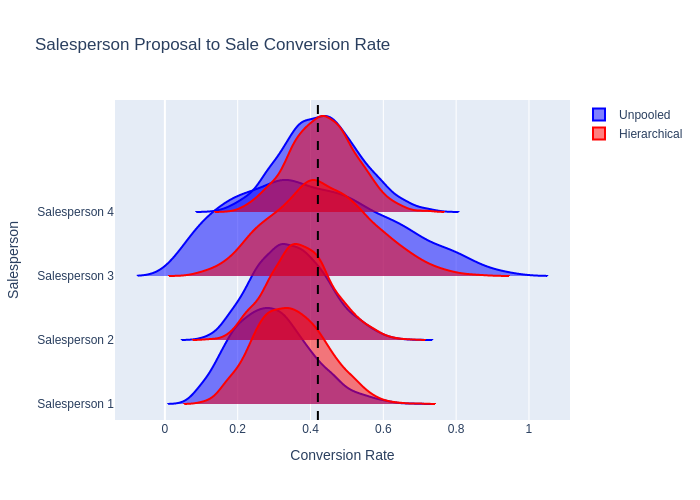

In [6]:
visual_cr = "proposal"
visual_df = cr_traces_df[
    (cr_traces_df["cr_type"] == f"{visual_cr}_cr") &
    (cr_traces_df["salesperson"] < 5)
]
line_color_map = {
    "unpooled": "blue",
    "hierarchical": "red"
}

fig = go.Figure()
for i, row in visual_df.iterrows():
    fig.add_trace(
        go.Violin(
            x=row["trace"], 
            line_color=line_color_map[row["model_type"]],
            name=f"Salesperson {row["salesperson"]}",
            hoverinfo='none',
            showlegend=False
        )
    )
fig.add_trace(go.Violin(x=[None], y=[None], line_color="blue", showlegend=True, name="Unpooled"))
fig.add_trace(go.Violin(x=[None], y=[None], line_color="red", showlegend=True, name="Hierarchical"))

fig.add_vline(x=h_cr_idata.posterior[f"mean_{visual_cr}_cr"].data.mean(), line_dash="dash", line_color="black")
fig.update_traces(orientation='h', side='positive', width=3, points=False)
fig.update_layout(title=f"Salesperson {visual_cr.capitalize()} to Sale Conversion Rate", xaxis_title="Conversion Rate", yaxis_title="Salesperson")
fig.show("png")

In [7]:
totaled_df[
    (totaled_df["salesperson"] < 5)
].sort_values("salesperson", ascending=False)[["salesperson", visual_cr]]

,salesperson,proposal
3,4,18.0
2,3,2.0
1,2,20.0
0,1,14.0


## Using the Model

- A benefit of hierarchical models is estimating values for groups/individuals not in the original dataset.

- Below are the average conversion rates estimated by the hyperprior

In [8]:
cr_means = []
cr_samples = []
for cr in crs:
    cr_mean = h_cr_idata.posterior[f"mean_{cr}"].data.mean()
    cr_samples.append(h_cr_idata.posterior[f"mean_{cr}"].data.reshape(-1))
    cr_means.append(cr_mean)
    print(f"Mean {cr}: {round(cr_mean, 3)}")

Mean outreach_cr: 0.243
Mean discovery_cr: 0.406
Mean demo_cr: 0.328
Mean proposal_cr: 0.42


### Adding a New Salesperson
- We can use those averages to back into how many leads, demos, etc. a new salesperson might need to get a certain number of sales
- Below is that for achieving 1 sale

In [9]:
stages = ["Outreach", "Discovery", "Demo", "Proposal", "Sale"]

desired_closed_wons = 1
funnel_counts = [desired_closed_wons]
funnel_samples = []
for m, samp_means in zip(cr_means, cr_samples):
    new_count = round(funnel_counts[0] / m)
    funnel_samples.append(funnel_counts[0] / samp_means)
    funnel_counts.insert(0, new_count)
print("-- Recommended Funnel Counts Based on Hyperpriors--")
for s, f in zip(stages, funnel_counts):
    print(f"{s}: {f}")
print()
print("-- Recommended Funnel Ranges Based on Hyperpriors (94% HDI)--")
for fs, s in zip(funnel_samples[::-1], stages):
    hdi = az.hdi(fs, 0.94)
    print(f"{s} Range: {hdi.round()}")

-- Recommended Funnel Counts Based on Hyperpriors--
Outreach: 71
Discovery: 30
Demo: 10
Proposal: 4
Sale: 1

-- Recommended Funnel Ranges Based on Hyperpriors (94% HDI)--
Outreach Range: [55. 93.]
Discovery Range: [23. 39.]
Demo Range: [ 8. 12.]
Proposal Range: [3. 5.]


### Updating the New Salesperson
- Right now the new salesperson has no data, but as they start working their data can be added to the model, which will improve their rate estimations.

In [10]:
test_outreach = 25
test_outreach_cr = 0.2
test_disc_cr = 0.4
test_demo_cr = 0.32
test_proposal_cr = 0.4
test_data = np.array([
    test_outreach, 
    round(test_outreach*test_outreach_cr), 
    round(test_outreach*test_outreach_cr*test_disc_cr), 
    round(test_outreach*test_outreach_cr*test_disc_cr*test_demo_cr), 
    round(test_outreach*test_outreach_cr*test_disc_cr*test_demo_cr*test_proposal_cr)
])
x_test = np.vstack((x, test_data))
print("-- Data for New Salesperson --")
for s, t in zip(stages, test_data):
    print(f"{s}: {t}")

-- Data for New Salesperson --
Outreach: 25
Discovery: 5
Demo: 2
Proposal: 1
Sale: 0


In [11]:
#https://en.wikipedia.org/wiki/Beta_distribution#Mean_and_sample_size

with pm.Model() as hierarchical_model:
    
    crs = ["outreach_cr", "discovery_cr", "demo_cr", "proposal_cr"]
    h_cr_idata = {}
    for i, cr in enumerate(crs):
        x1 = x_test[:, i]
        x2 = x_test[:, i+1]
    
        mu = pm.Beta(f'mu_{cr}', 1, 1)
        nu = pm.Gamma(f'nu_{cr}', alpha=10, beta=1)
        a = pm.Deterministic(f'a_{cr}', mu * nu)
        b = pm.Deterministic(f'b_{cr}', (1 - mu) * nu)
        mean = pm.Deterministic(f'mean_{cr}', a / (a + b))
        
        cr = pm.Beta(f'{cr}', alpha=a, beta=b, shape=x1.shape[0])
        conversions = pm.Binomial(f"conversions_{cr}", n=x1, p=cr, shape=x1.shape[0], observed=x2)
        
    h_cr_prior_pred = pm.sample_prior_predictive(samples=1000)
    h_cr_idata = pm.sample()

Sampling: [conversions_demo_cr, conversions_discovery_cr, conversions_outreach_cr, conversions_proposal_cr, demo_cr, discovery_cr, mu_demo_cr, mu_discovery_cr, mu_outreach_cr, mu_proposal_cr, nu_demo_cr, nu_discovery_cr, nu_outreach_cr, nu_proposal_cr, outreach_cr, proposal_cr]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_outreach_cr, nu_outreach_cr, outreach_cr, mu_discovery_cr, nu_discovery_cr, discovery_cr, mu_demo_cr, nu_demo_cr, demo_cr, mu_proposal_cr, nu_proposal_cr, proposal_cr]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


- After updating the model with new data, we can re-estimate how much activity it would take to achieve 1 sale

In [12]:
test_cr_means = []
test_cr_samples = []
print("-- New Salesperson Conversion Rates w/ Added Data--")
for cr in crs:
    test_cr_mean = h_cr_idata.posterior[f"{cr}"].data[:, :, -1].mean()
    test_cr_samples.append(h_cr_idata.posterior[f"mean_{cr}"].data.reshape(-1))
    test_cr_means.append(test_cr_mean)
    print(f"Mean {cr}: {round(test_cr_mean, 3)}")

-- New Salesperson Conversion Rates w/ Added Data--
Mean outreach_cr: 0.214
Mean discovery_cr: 0.406
Mean demo_cr: 0.355
Mean proposal_cr: 0.378


In [13]:
desired_closed_wons = 1
funnel_counts = [desired_closed_wons]
funnel_samples = []
for m, samp_means in zip(test_cr_means, test_cr_samples):
    new_count = round(funnel_counts[0] / m)
    funnel_samples.append(funnel_counts[0] / samp_means)
    funnel_counts.insert(0, new_count)
print("-- Recommended Funnel Counts Based on Hyperpriors--")
for s, f in zip(stages, funnel_counts):
    print(f"{s}: {f}")    

print()

print("-- Recommended Funnel Ranges Based on Hyperpriors (94% HDI)--")
for fs, s in zip(funnel_samples[::-1], stages):
    hdi = az.hdi(fs, 0.94)
    print(f"{s} Range: {hdi.round()}")

-- Recommended Funnel Counts Based on Hyperpriors--
Outreach: 90
Discovery: 34
Demo: 12
Proposal: 5
Sale: 1

-- Recommended Funnel Ranges Based on Hyperpriors (94% HDI)--
Outreach Range: [ 62. 106.]
Discovery Range: [28. 47.]
Demo Range: [10. 15.]
Proposal Range: [3. 5.]


### Other Use Cases
- This same exercise could be done on the other salespeople to check what kind of sales activity would be needed to meet increased sales goals